# Signal Feature Extraction 

## Imports

In [1]:
#library imports
from analysis_helpers import *
import os
from time import sleep

## Set Datapaths

In [2]:
#experiment title
title = "BCI"

#current path
os.chdir("..")
cwd = os.getcwd()

#get subject info
subject_info = get_subject_info(title)


#paths
logfile = os.path.join(cwd,f'data/{subject_info}/{subject_info}_log.log')
eeg_df = os.path.join(cwd,f'data/{subject_info}/{subject_info}_eeg.csv')
experiment_df = os.path.join(cwd,f'data/{subject_info}/{subject_info}.csv')


## Load EEG Data by Task

In [3]:


#minimum samples recorded 
minimum = 1872


#apply band pass filters to data
df = pd.read_csv(experiment_df)

#eeg data (trials,electrodes,samples )
eeg_data = []

#per trial
for index,row in df.iterrows():

    #samples: (1875x25)
    samples = literal_eval(df.loc[index,'Trial EEG Samples'])

    #electrode array is of shape (~1875x20)
    trial_data = []
    timestamps = []

    for sample in samples[:minimum]:
        #separate out timestamps and voltage values from eeg samples
        electrode_array = sample[0][:20]
        trial_data.append(electrode_array)
        timestamps.append(sample[1])

    #transpose trial data to be electrodesxsamples 
    trial_data = np.transpose(trial_data)
    eeg_data.append(trial_data)
   
        
eeg_data = np.array(eeg_data)
        




## Plot Raw Data

(6, 20, 1872)


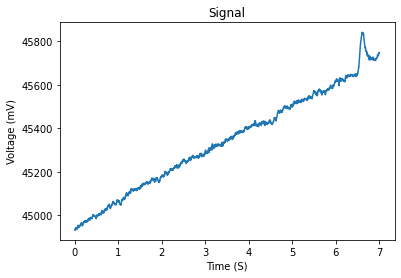

In [5]:

plot_signal(eeg_data[0][0])
print(eeg_data.shape)

## Extract Sub-band

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



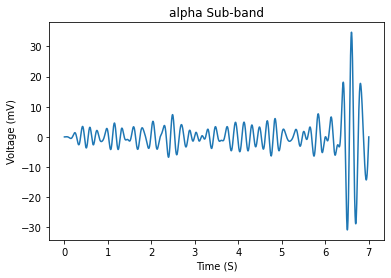

In [6]:
band = 'alpha'

band_data = extract_band(eeg_data,fs=500,band=band)
band_data.shape
plot_signal(band_data[0][0],name=str(band)+" Sub-band")

# df['Feature Vector'] = band_data

## Apply Bandpass filter

Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)



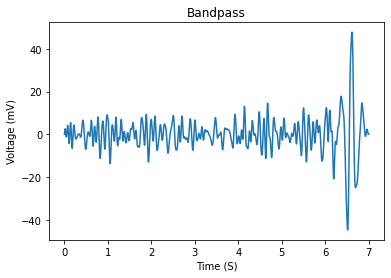

In [7]:
bandpass_data = bandpass_filter(eeg_data)
bandpass_data.shape
plot_signal(bandpass_data[0][0],name='Bandpass')

# df['Feature Vector'] = bandpass_data

## Apply DWT 

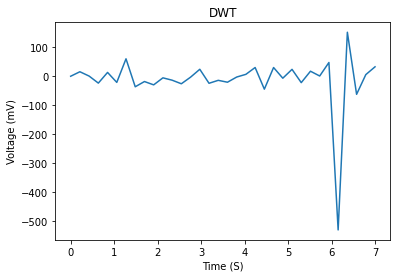

In [8]:
dwt_data = []
for trial in eeg_data:
    trial_data = []
    for signal in trial:  
        trial_data.append(downcoef('d', signal, 'coif1', level=6)) 
    dwt_data.append(trial_data)


plot_signal(dwt_data[0][0],name='DWT')

# df['Feature Vector'] = dwt_data

## Get Power Spectral Density

/Users/alejandromartinez/.local/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  from ipykernel import kernelapp as app


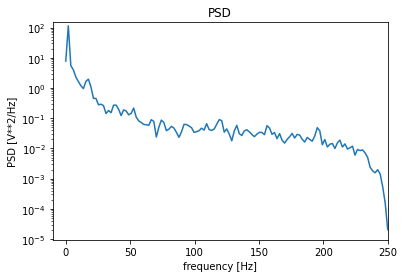

In [9]:
psd_data = []
freq = []
first = True
for trial in eeg_data:
    trial_data = []
    for signal in trial:  
        f, Pxx_den = sg.welch(signal,fs=500)
        if first:
            freq =f
            first = False
        trial_data.append(Pxx_den)
    psd_data.append(trial_data)
            
plt.semilogy(freq, psd_data[0][0])
plt.ylim([0, 150])
plt.xlim([-10, 250])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('PSD')
plt.show()

# df['Feature Vector'] = psd_data

## Apply Hilbert Transform

/Users/alejandromartinez/anaconda3/lib/python3.7/site-packages/scipy/fftpack/basic.py:153: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  x = x[index]
/Users/alejandromartinez/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


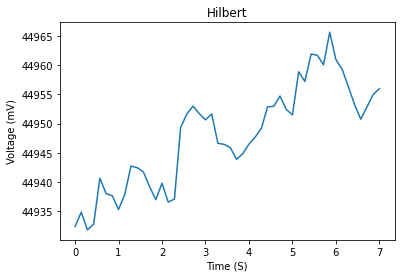

In [11]:
#python hilbert

hilbert_data = []

for trial in eeg_data:
    trial_data = []
    for signal in trial:  
        y = sg.hilbert(signal,N=50)
        trial_data.append(y)
    hilbert_data.append(trial_data)
   
    
plot_signal(hilbert_data[0][0],name='Hilbert')

#df['Feature Vector'] = hilbert_data

## Save to DataFrame as Feature Vector

In [13]:
df.to_csv(experiment_df)